In [ ]:
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Optimized_PySpark") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.sql.files.maxPartitionBytes", "256MB") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

from pyspark.sql.functions import udf, lit # udf: User Defined Function
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from functools import reduce

GPU Available: True
GPU Name: Tesla T4


In [ ]:
# Select the full "CIC-IoT 2023" dataset from where it is located (change path accordingly)
df = spark.read.format("csv").option("header", True).option("inferSchema", True).load("\\CICIoT2023\\*.csv")

# Select benign traffic samples
df_benign = df.filter(df.label == 'BenignTraffic').withColumn("grouped_label", lit("Benign"))

In [4]:
label_mapping = {
    # DDoS
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    
    # DoS
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-UDP_Flood': 'DoS',
    
    # Brute Force
    'DictionaryBruteForce': 'Brute Force',
    
    # Spoofing
    'MITM-ArpSpoofing': 'Spoofing',
    'DNS_Spoofing': 'Spoofing',
    
    # Recon
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    
    # Web-based
    'SqlInjection': 'Web-based',
    'CommandInjection': 'Web-based',
    'Backdoor_Malware': 'Web-based',
    'Uploading_Attack': 'Web-based',
    'XSS': 'Web-based',
    'BrowserHijacking': 'Web-based',
    
    # Mirai
    'Mirai-greip_flood': 'Mirai',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    
    # Benign Traffic
    'BenignTraffic': 'Benign'
}

In [ ]:
# Assign category labels to each attack type to improve the processing

def map_labels(label):
    return label_mapping.get(label, 'Unknown')  # default to 'Unknown' for any unmapped labels

map_labels_udf = udf(map_labels, StringType())
df = df.withColumn('grouped_label', map_labels_udf(F.col('label')))
grouped_label_counts = df.groupBy('grouped_label').count().orderBy('count', ascending=False)

grouped_label_counts.show()

+-------------+--------+
|grouped_label|   count|
+-------------+--------+
|         DDoS|33984560|
|          DoS| 8090738|
|        Mirai| 2634124|
|       Benign| 1098195|
|     Spoofing|  486504|
|        Recon|  354565|
|    Web-based|   24829|
|  Brute Force|   13064|
+-------------+--------+



Generate an equitative and reduced dataset.

In [ ]:
categories = ['DDoS', 'DoS', 'Recon', 'Web-based', 'Brute Force', 'Spoofing', 'Mirai']
total_attack_samples = 1200000 
samples_type = 37000

In [ ]:
df_eq_sampled = None

staging_output_folder = "..\\datasets\\StagingEquitativeDataset"
os.makedirs(staging_output_folder, exist_ok=True)

for idx, cat in enumerate(categories):
    print(f"=============================== {cat} ===============================")
    # Select rows for the current category
    df_filtered = df.filter(df.grouped_label == cat)

    # Get unique attack types in this category
    attacks = [row['label'] for row in df_filtered.select('label').distinct().collect()]
    
    # Equitative sampled data per attack
    sampled_attacks = []

    for attack in attacks:
        df_attack = df_filtered.filter(df_filtered.label == attack)
        samples_per_attack =  min(df_attack.count(), samples_type)
        df_attack = df_attack.orderBy(F.rand()).limit(samples_per_attack)
        sampled_attacks.append(df_attack)

    # Union all sampled attack for this category
    df_filtered = reduce(lambda df1, df2: df1.union(df2), sampled_attacks)
    
    # Create a distinct folder for each category: PySpark generates multiple CSV of data
    cat_dir = f"{staging_output_folder}/category_{cat}"
    os.makedirs(cat_dir, exist_ok=True)

    df_filtered.write.mode("overwrite").option("header", "true").csv(cat_dir)
    df_filtered.groupBy('label').count().orderBy('count', ascending=False).show()
        
    csv_files = [f for f in os.listdir(cat_dir) if f.endswith(".csv")]
    print(f"Generated files for the Equitative Dataset category {cat}:")
    print(csv_files)

=============================== DDoS ===============================
+--------------------+-----+
|               label|count|
+--------------------+-----+
|    DDoS-RSTFINFlood|37000|
|DDoS-ACK_Fragment...|37000|
|DDoS-ICMP_Fragmen...|37000|
|DDoS-SynonymousIP...|37000|
|      DDoS-SYN_Flood|37000|
|      DDoS-TCP_Flood|37000|
|   DDoS-PSHACK_Flood|37000|
|      DDoS-UDP_Flood|37000|
|DDoS-UDP_Fragment...|37000|
|     DDoS-ICMP_Flood|37000|
|     DDoS-HTTP_Flood|28790|
|      DDoS-SlowLoris|23426|
+--------------------+-----+

Generated files for the Equitative Dataset category DDoS:
['part-00007-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00006-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00001-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00003-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00002-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00008-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd4-c000.csv', 'part-00005-63b52229-ab8d-4ee1-9ae5-2b0226ce0bd

In [ ]:
# Select all the obtained CSVs of cyberattacks (each starts with "part-")
df_eq = spark.read.format("csv").option("header", True).option("inferSchema", True).load(f"{staging_output_folder}/*/part-*.csv")

In [ ]:
df_eq_full = df_eq.union(df_benign) # Combine benign and malicious traffic samples

final_output_folder = "..\\datasets\\EquitativeDataset"
os.makedirs(final_output_folder, exist_ok=True)
df_eq_full.coalesce(1).write.csv(final_output_folder, header=True, mode="overwrite") # Rename the CSV afterwards

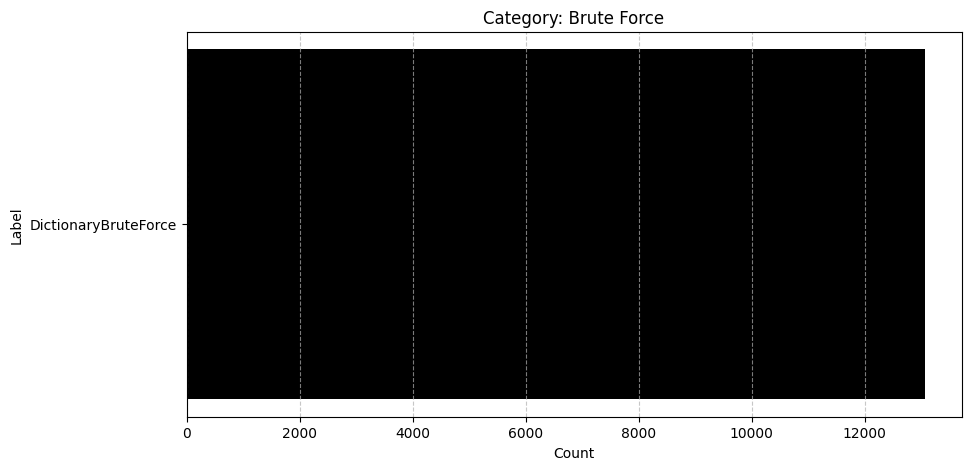

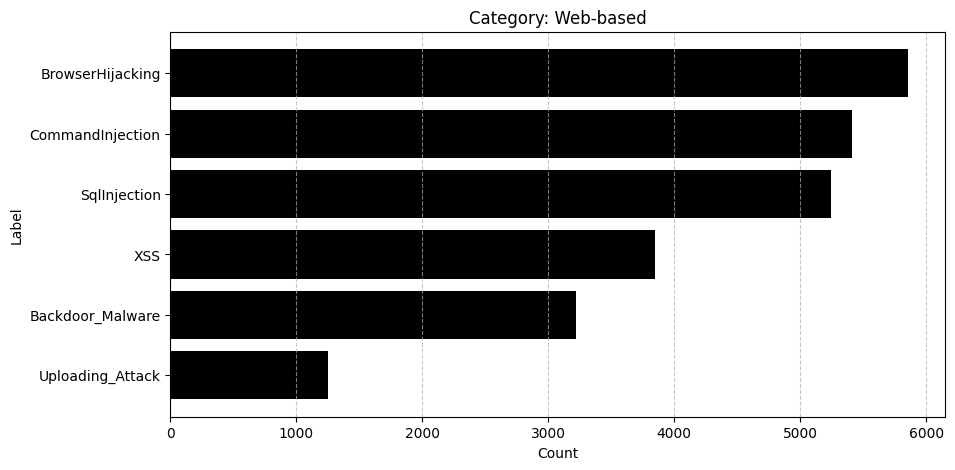

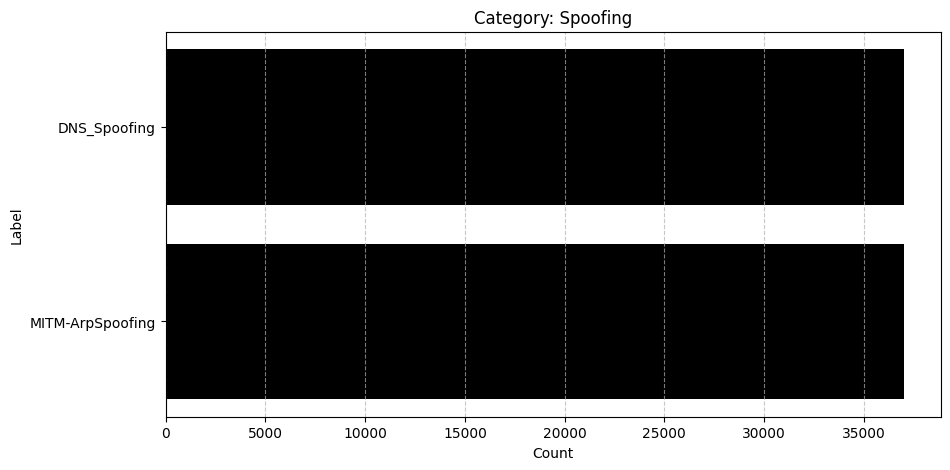

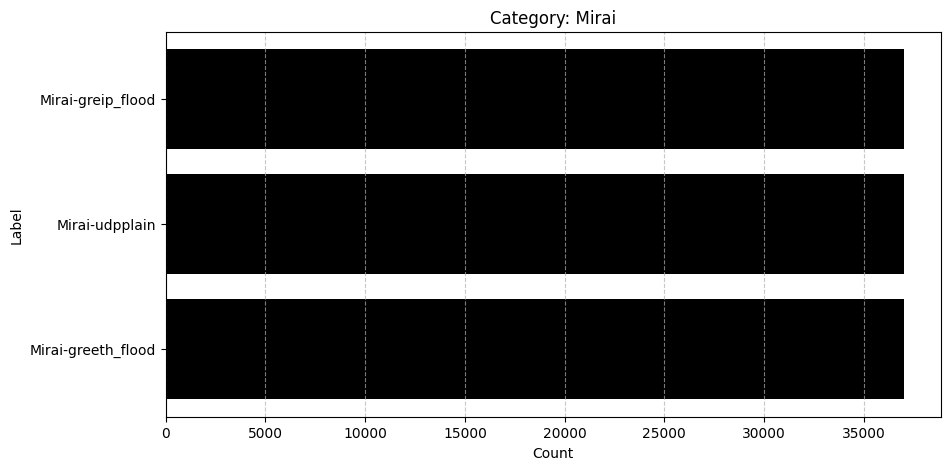

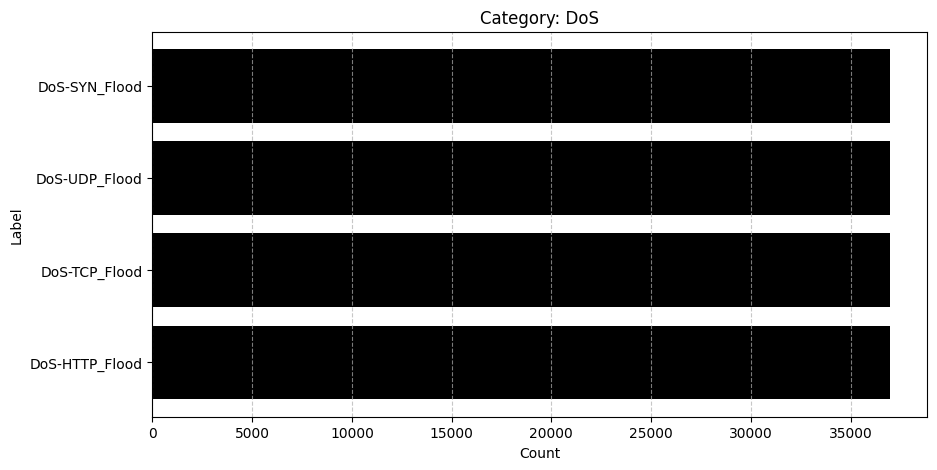

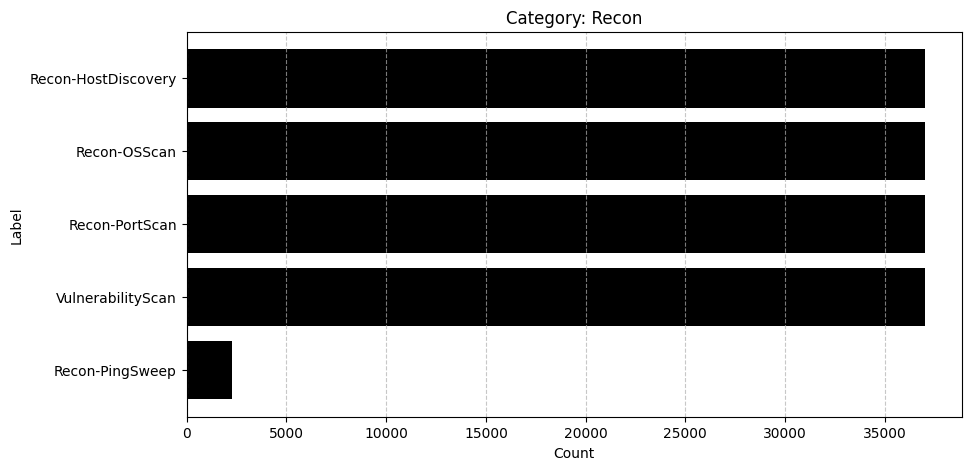

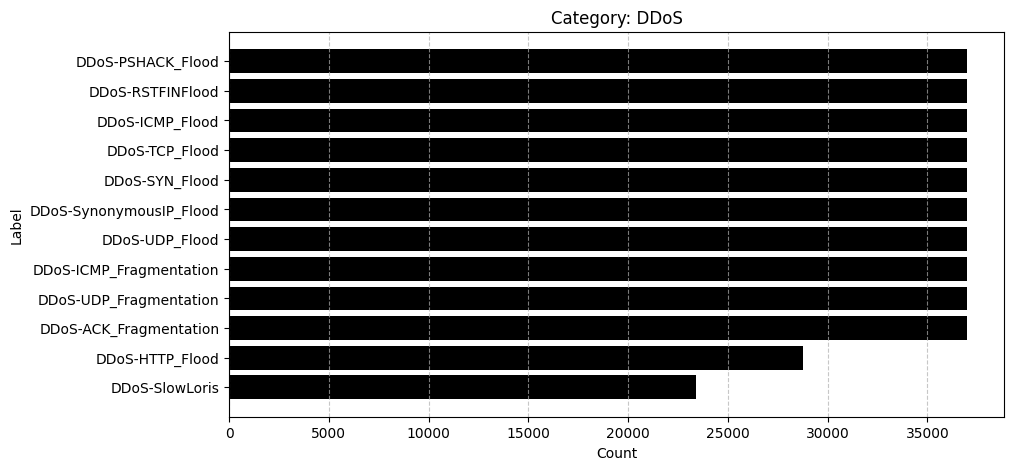

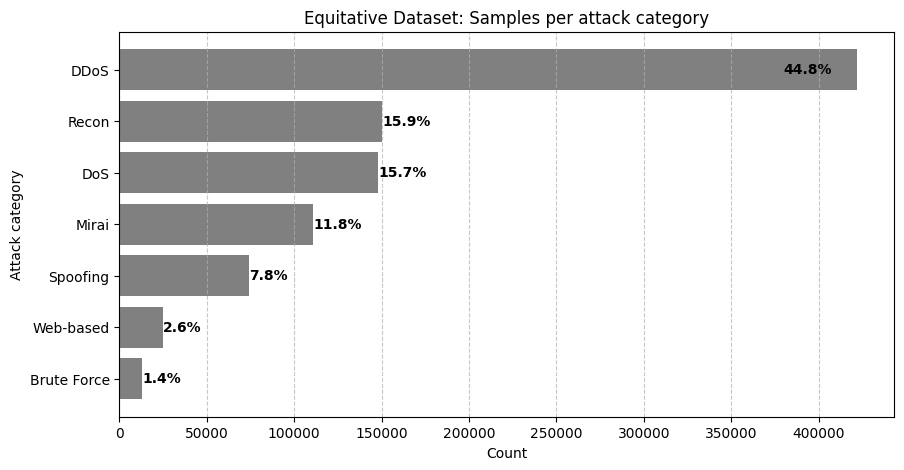

In [ ]:
# Analysis of the performed dataset processing 

df_eq_cat = df_eq.groupBy("grouped_label").count().orderBy("count", ascending=True).toPandas()
df_eq_attacks = df_eq.groupBy("grouped_label", "label").count().orderBy("count", ascending=True).toPandas()

categories = df_eq_cat["grouped_label"].unique()
palette = sns.color_palette("twilight_shifted", len(categories)) 
color_map = dict(zip(categories, palette))

for cat in categories:
    subset = df_eq_attacks[df_eq_attacks["grouped_label"] == cat]
    plt.figure(figsize=(10, 5))
    plt.barh(subset["label"], subset["count"], color="black")
    plt.xlabel("Count")
    plt.ylabel("Label")
    plt.title(f"Category: {cat}")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()


total_count_eq = df_eq_cat["count"].sum()

plt.figure(figsize=(10, 5))
plt.barh(df_eq_cat["grouped_label"], df_eq_cat["count"], color="grey")
plt.xlabel("Count")
plt.ylabel("Attack category")
plt.title("Equitative Dataset: Samples per attack category")
plt.grid(axis="x", linestyle="--", alpha=0.7)

for index, (value, label) in enumerate(zip(df_eq_cat["count"], df_eq_cat["grouped_label"])):
    percentage = (value / total_count_eq) * 100
    text_position = min(value + 0.5, df_eq_cat["count"].max() * 0.9)
    plt.text(text_position, index, f"{percentage:.1f}%", va="center", color='black', fontweight="bold")

plt.show()

In [ ]:
# Remove all the content of the staging folder 
shutil.rmtree(staging_output_folder)